# Laboratorio Final - Reinforcement learning
A continuacióón se implementaran algoritmos de Aprendizaje por Refuerzo requeridos para la aprobación de esta materia electiva de la Diplomatura en Ciencia de Datos, Aprendizaje Automatico y sus aplicaciones.
El primero en implementarse es Double DQN, luego se implementará Dueling DQN y por último probaremos otro entorno de la libreria gym - openAI para los mismos algoritmos.

## Implementacion de Double DQN

In [0]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition

In [0]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # nn.init.kaiming_normal_(m.weight) -> Literature suggest that using an initialization "He" we could better
                # results for relu activations. Either way we continue using xavier initialization because, we do not see a
                # real inprovement in final reward calculation. 
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [0]:
class DDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.8,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-4,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])       
        non_final_mask = torch.stack([d for d in batch.done])
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            _ , next_state_action = self.model(non_final_next_states).max(1, keepdim=True)
            next_state_values[non_final_mask] = self.target(non_final_next_states).gather(1, next_state_action).squeeze()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values
        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [0]:
agent = DDQN(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward 12.0.
[Episode 100] - Mean reward 13.336633663366337.
[Episode 200] - Mean reward 34.004975124378106.
[Episode 300] - Mean reward 78.78073089700996.
[Episode 400] - Mean reward 98.20947630922693.
[Episode 500] - Mean reward 100.73652694610779.
[Episode 600] - Mean reward 100.74209650582362.
[Episode 700] - Mean reward 97.37945791726105.
[Episode 800] - Mean reward 97.60174781523096.
[Episode 900] - Mean reward 99.38956714761376.
[Episode 1000] - Mean reward 98.82817182817183.
[Episode 1100] - Mean reward 100.31516802906448.
[Episode 1200] - Mean reward 100.97418817651956.
[Episode 1300] - Mean reward 102.14296694850115.
[Episode 1400] - Mean reward 106.17059243397573.
[Episode 1500] - Mean reward 108.8294470353098.
[Episode 1600] - Mean reward 110.22173641474079.
[Episode 1700] - Mean reward 111.21575543797766.
[Episode 1800] - Mean reward 113.48084397556913.
[Episode 1900] - Mean reward 114.13098369279327.
[Episode 2000] - Mean reward 114.82858570714643.
[Epi

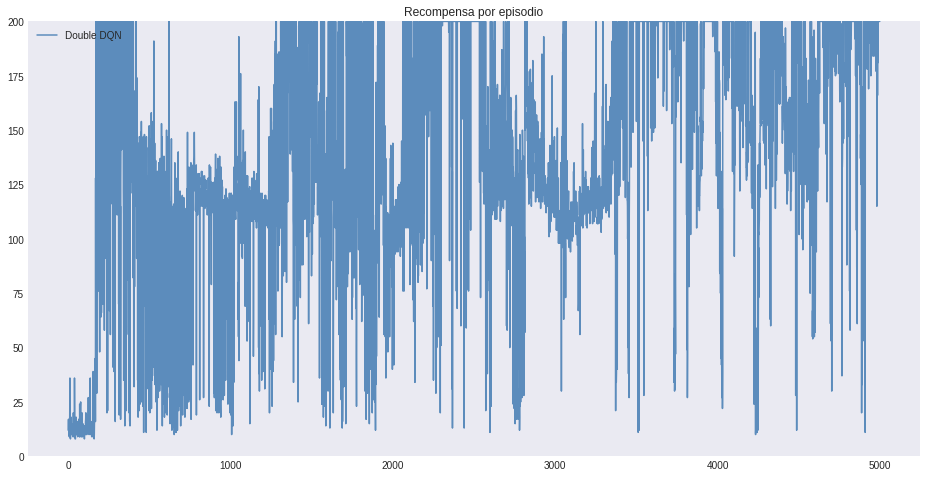

In [0]:
plt.plot(np.array(scoresDDQN), label='Double DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

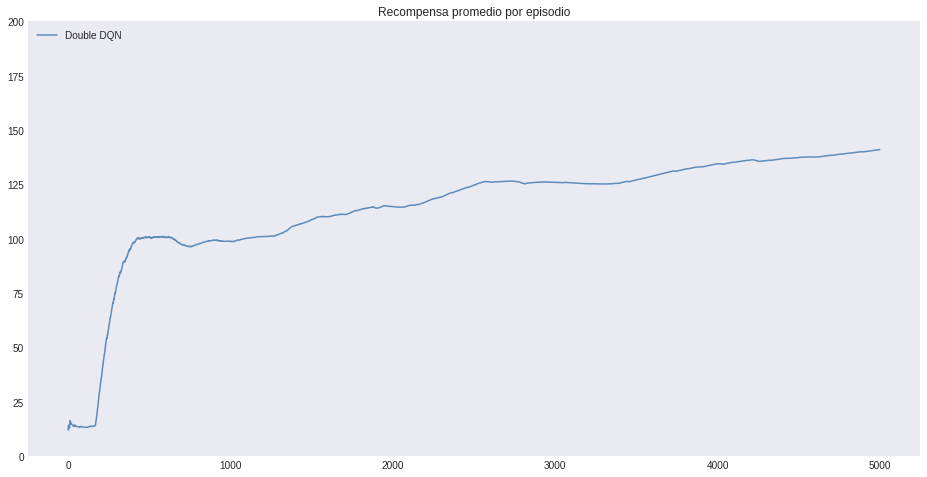

In [0]:
plt.plot(np.array(meanDDQN), label='Double DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

Observemos que el reward promedio aumenta con el paso de los episodios y se encuentra con una pendiente positiva al momento de finalizacion de la cantidad de episodios, por lo cual podemos asumir que si trabajasemos con una mayor cantidad de episodios el reward promedio aumentaria aun mas.

## Implementación de Dueling DQN

In [0]:
class DuelingNet(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(DuelingNet, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.advantage = nn.Linear(_hidden_size, _output_size)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        
        a = F.relu(self.advantage(x))
        x = self.output(x)
        return x + a - a.mean()#dueling

In [0]:
class DuelingDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = DuelingNet(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = DuelingNet(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [0]:
agent = DuelingDQN(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresDuelingDQN, meanDuelingDQN = agent.run()

[Episode 0] - Mean reward 18.0.
[Episode 100] - Mean reward 62.56435643564357.
[Episode 200] - Mean reward 61.298507462686565.
[Episode 300] - Mean reward 62.04983388704319.
[Episode 400] - Mean reward 60.057356608478806.
[Episode 500] - Mean reward 61.249500998003995.
[Episode 600] - Mean reward 61.15640599001664.
[Episode 700] - Mean reward 62.71041369472183.
[Episode 800] - Mean reward 65.84269662921348.
[Episode 900] - Mean reward 68.11764705882354.
[Episode 1000] - Mean reward 70.19080919080919.
[Episode 1100] - Mean reward 71.66030881017257.
[Episode 1200] - Mean reward 73.7060782681099.
[Episode 1300] - Mean reward 75.68408916218294.
[Episode 1400] - Mean reward 79.43683083511777.
[Episode 1500] - Mean reward 81.30512991339107.
[Episode 1600] - Mean reward 84.11742660836977.
[Episode 1700] - Mean reward 87.37154614932393.
[Episode 1800] - Mean reward 90.68017767906719.
[Episode 1900] - Mean reward 93.5228826933193.
[Episode 2000] - Mean reward 95.16691654172914.
[Episode 2100] -

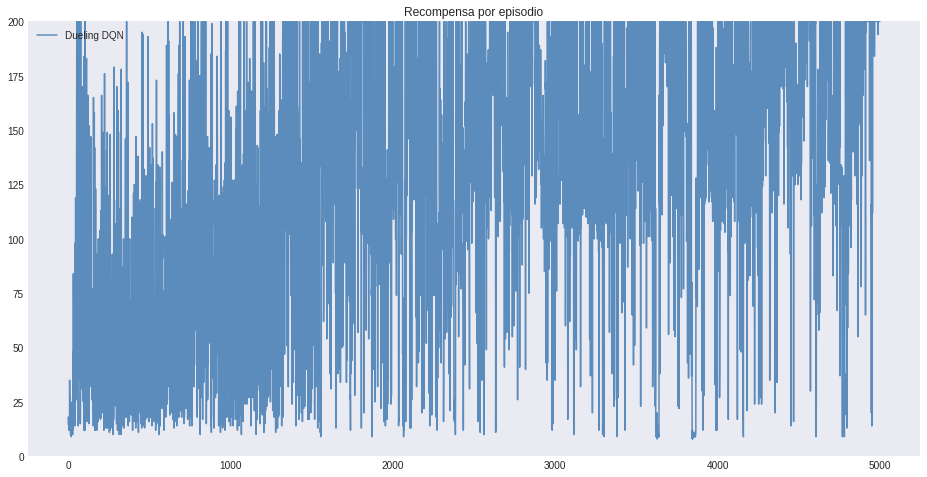

In [0]:
plt.plot(np.array(scoresDuelingDQN), label='Dueling DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

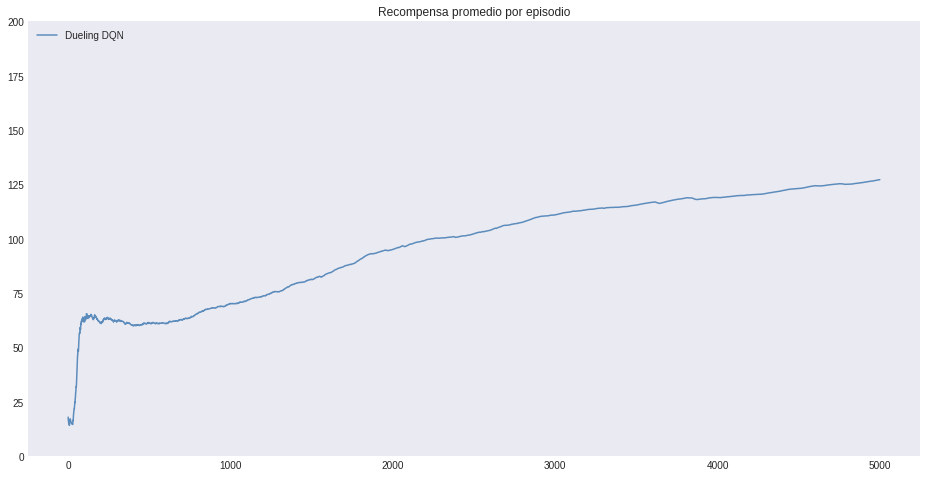

In [0]:
plt.plot(np.array(meanDuelingDQN), label='Dueling DQN', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## Probamos las implementaciones con otro entorno de OpenAI gym - MountainCar-v0

In [9]:
agent = DDQN(gym.make('MountainCar-v0'), n_episodes=3000, debug=True)
scoresDDQN_mc, meanDDQN_mc = agent.run()

[Episode 0] - Mean reward -200.0.
[Episode 100] - Mean reward -200.0.
[Episode 200] - Mean reward -200.0.
[Episode 300] - Mean reward -199.91029900332225.
[Episode 400] - Mean reward -199.93266832917706.
[Episode 500] - Mean reward -199.94610778443115.
[Episode 600] - Mean reward -199.955074875208.
[Episode 700] - Mean reward -199.9614835948645.
[Episode 800] - Mean reward -199.95630461922596.
[Episode 900] - Mean reward -199.96115427302996.
[Episode 1000] - Mean reward -199.96503496503496.
[Episode 1100] - Mean reward -199.66121707538602.
[Episode 1200] - Mean reward -198.6519567027477.
[Episode 1300] - Mean reward -197.47809377401998.
[Episode 1400] - Mean reward -195.9478943611706.
[Episode 1500] - Mean reward -195.00999333777483.
[Episode 1600] - Mean reward -193.39225484072455.
[Episode 1700] - Mean reward -192.86831275720164.
[Episode 1800] - Mean reward -193.26429761243753.
[Episode 1900] - Mean reward -193.5802209363493.
[Episode 2000] - Mean reward -193.13793103448276.
[Episod

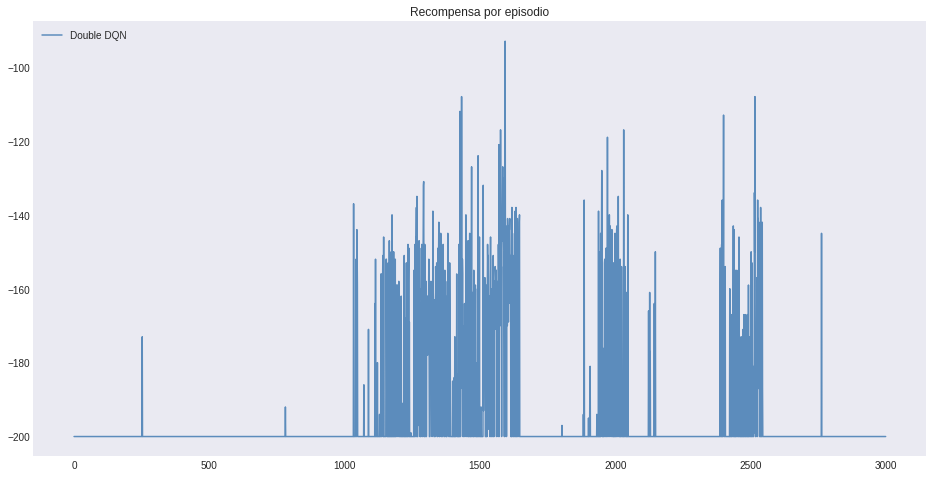

In [10]:
plt.plot(np.array(scoresDDQN_mc), label='Double DQN', c='#5c8cbc')
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

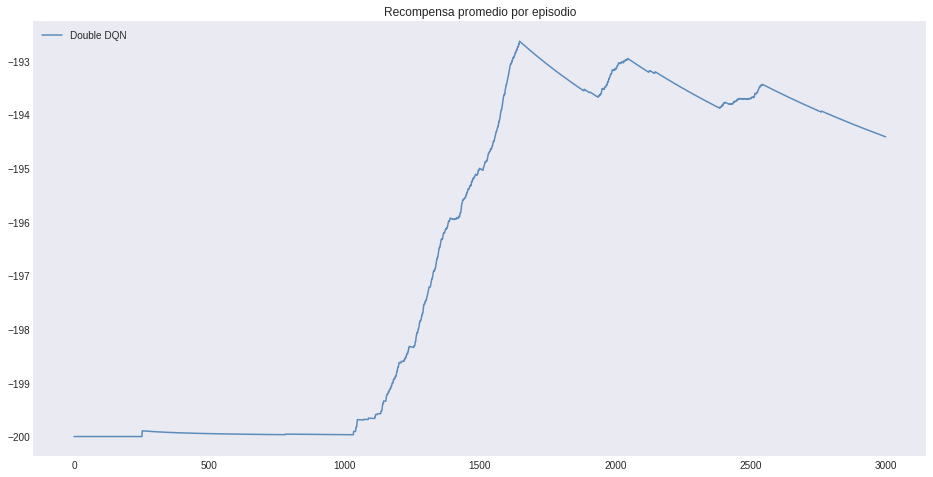

In [11]:
plt.plot(np.array(meanDDQN_mc), label='Double DQN', c='#5c8cbc')
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

In [10]:
agent = DuelingDQN(gym.make('MountainCar-v0'), n_episodes=3000, debug=True)
scoresDuelingDQN_mc, meanDuelingDQN_mc = agent.run()

[Episode 0] - Mean reward -200.0.
[Episode 100] - Mean reward -200.0.
[Episode 200] - Mean reward -200.0.
[Episode 300] - Mean reward -200.0.
[Episode 400] - Mean reward -200.0.
[Episode 500] - Mean reward -200.0.
[Episode 600] - Mean reward -200.0.
[Episode 700] - Mean reward -199.97146932952924.
[Episode 800] - Mean reward -199.65043695380774.
[Episode 900] - Mean reward -199.5305216426193.
[Episode 1000] - Mean reward -199.57742257742257.
[Episode 1100] - Mean reward -199.60036330608537.
[Episode 1200] - Mean reward -199.59283930058285.
[Episode 1300] - Mean reward -199.47809377401998.
[Episode 1400] - Mean reward -199.26837972876515.
[Episode 1500] - Mean reward -197.68021319120587.
[Episode 1600] - Mean reward -196.68582136164898.
[Episode 1700] - Mean reward -196.17519106407994.
[Episode 1800] - Mean reward -196.38756246529707.
[Episode 1900] - Mean reward -196.46659652814307.
[Episode 2000] - Mean reward -196.6311844077961.
[Episode 2100] - Mean reward -196.79152784388387.
[Epis

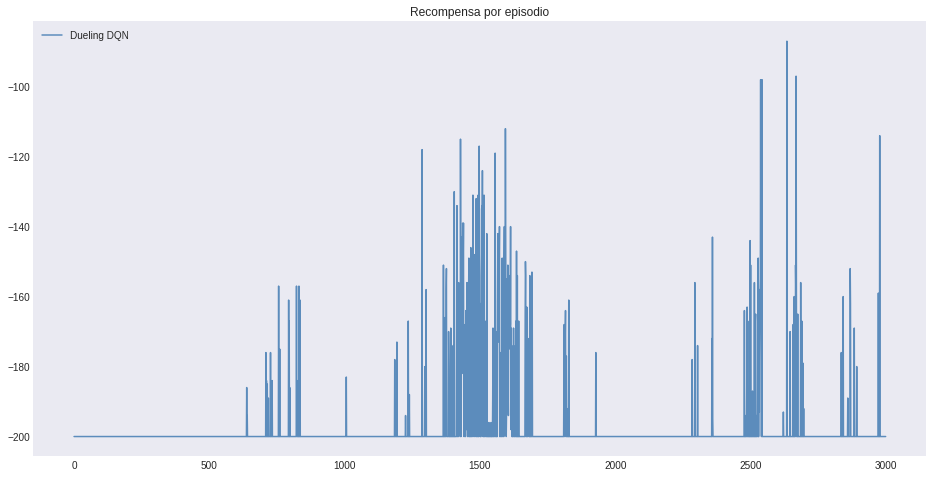

In [11]:
plt.plot(np.array(scoresDuelingDQN_mc), label='Dueling DQN', c='#5c8cbc')
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

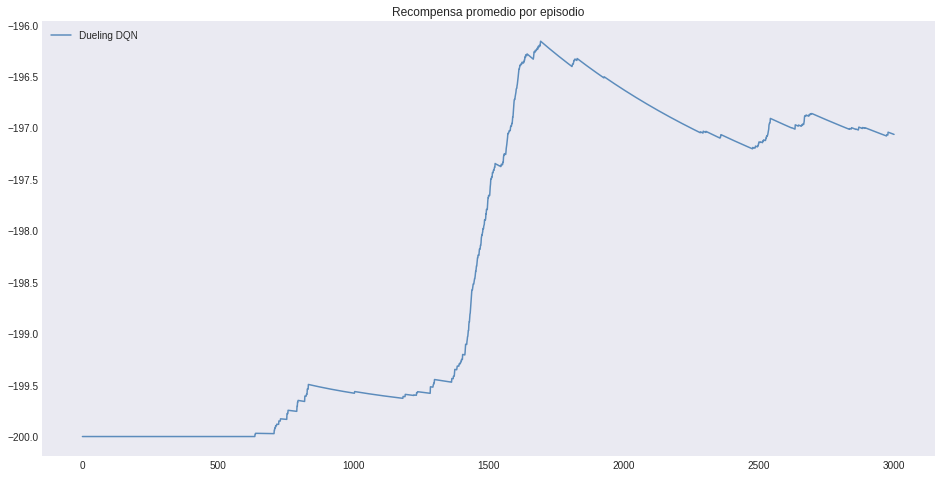

In [12]:
plt.plot(np.array(meanDuelingDQN_mc), label='Dueling DQN', c='#5c8cbc')
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()